In [15]:
import pandas as pd; pd.options.display.float_format = '{:,.2f}'.format
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style("dark")
from IPython.display import display

## Cleaning and data prep

In [16]:
def merge_columns(df, columns):
    return (
        df[columns]
        .stack()
        .reset_index()
        .set_index('level_0')
        .where(lambda df: df[0] != 0)
        .dropna()
        .drop(0, axis=1)
    )

data2014 = pd.read_csv('data/data2014.csv').assign(year=2014)
data2015 = pd.read_csv('data/data2015.csv').assign(year=2015)
data = pd.concat([data2014, data2015], axis=0).reset_index(drop=True)

data = (
    data
    .assign(
        provider=merge_columns(data, ['Bank', 'Dealer', 'Volunteer', 'Liquidator']),
        day_period=merge_columns(data, ['Morning', 'Afternoon', 'Evening']),
        sale_price=data['EstValue'] * data['multiplier'],
        log_multipl=np.log10(data['multiplier']),
        log_estval=np.log10(data['EstValue']),
        log_sp=np.log10(data["StartPrice"]),
        log_spev=np.log10(data["SP.EV"])
    )
    
)

### Multiplier of the Estimated Value

The value to optimise is the ratio between the sale price and the estimated value. The distribution is highly skewed. 98% of the values are comprised between 0 and 5 but the values range between 0 and 57. Extreme values are common more than 1% of the time. 
For this reason, we take the logarithm of price related values.

year,2014,2015
count,"6,901.00","4,415.00"
mean,1.15,1.34
std,1.03,2.02
min,0.01,0.06
25%,0.67,0.73
50%,0.80,0.93
75%,1.29,1.40
max,19.50,57.00


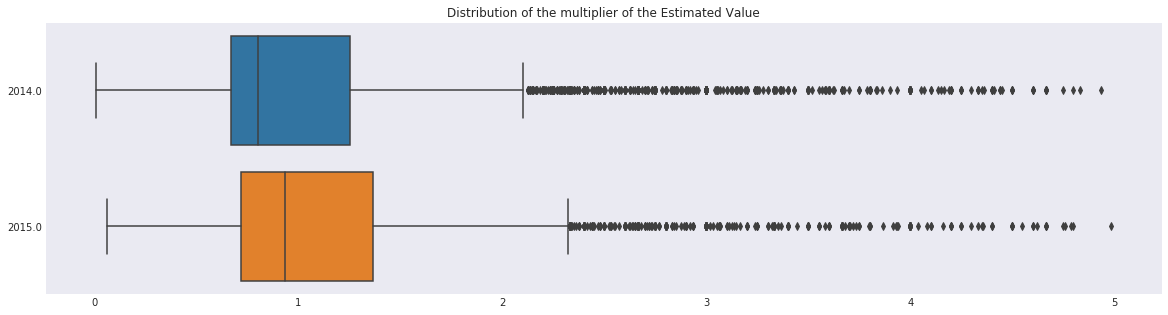

In [19]:
def empty_axes(figsize):
    fig = plt.figure(figsize=figsize)
    return fig.add_subplot(111)

ax = sns.boxplot(
    x="multiplier", 
    y="year", 
    orient="h", 
    data=data.where(data["multiplier"] < 5).dropna(), 
    ax=empty_axes((20,5))
)

display(pd.DataFrame(data.pivot(columns="year", values="multiplier").describe()))
ax.set_xlabel(""); ax.set_ylabel(""); ax.set_title("Distribution of the multiplier of the Estimated Value");

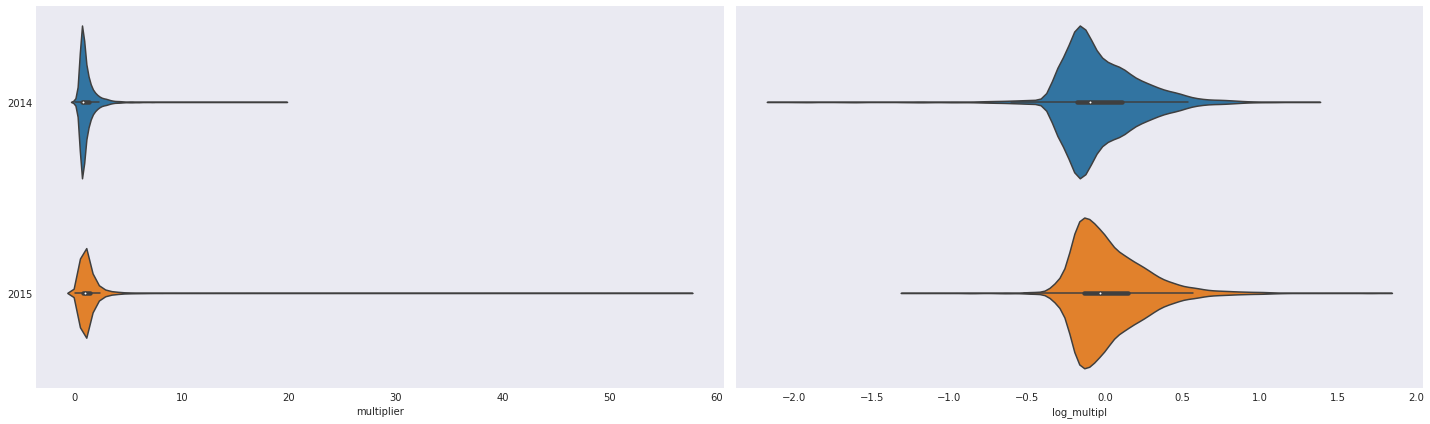

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(20, 6), sharey=True)
for name, ax in zip(["multiplier", "log_multipl"], axs):
    sns.violinplot(x=name, y="year", orient='h', data=data, ax=ax)
    ax.set_ylabel("")
plt.tight_layout()

## Correlation matrix

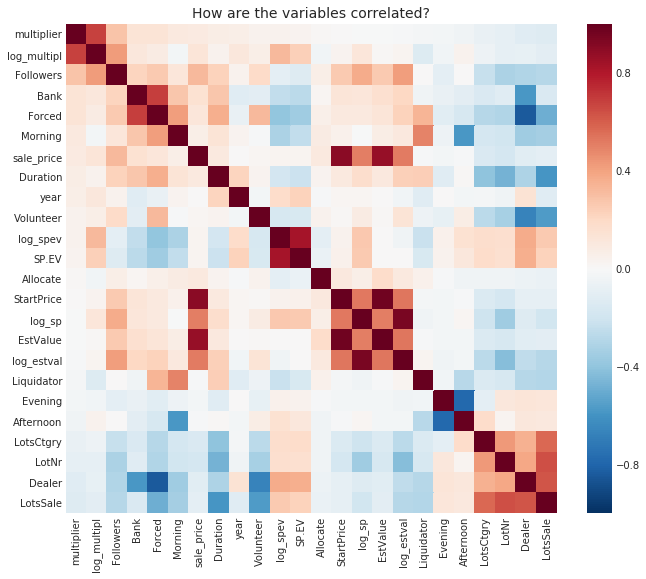

In [38]:
corr = data.corr().sort_values("multiplier", ascending=False)
corr = corr[corr.index]
sns.heatmap(corr, cmap="RdBu_r", vmax=1, vmin=-1, ax=empty_axes((11,9)))
plt.title('How are the variables correlated?', size= 14);

### Multiplier, Start Price and Estimated Value

There seem to be a relation between the ratio of the start price and the estimated value and the multiplier. The relation is exponential. By taking the logarithm of the values, a linear relation appears.

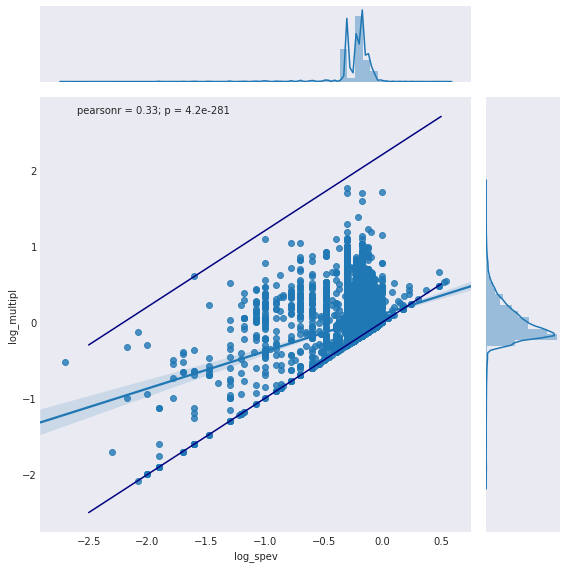

In [6]:
g = sns.jointplot(x="log_spev", y="log_multipl", data=data, kind='reg', size=8)
x = np.linspace(-2.5, .5, 100); [g.ax_joint.plot(x, x + c, c='navy') for c in (0., 2.2)];

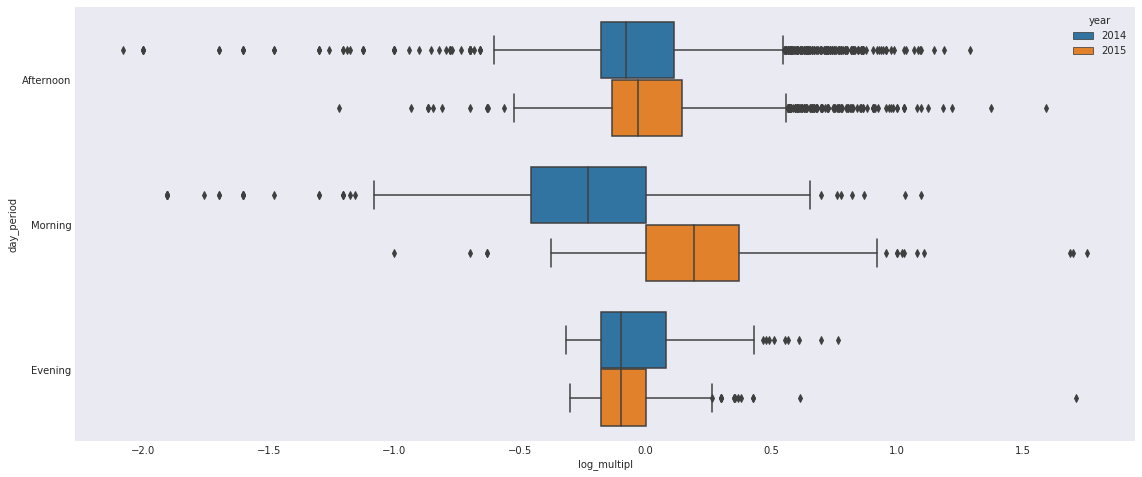

In [153]:
fig = plt.figure(figsize=(19,8)); ax = fig.add_subplot(111)
sns.boxplot(x="log_multipl", y="day_period", hue="year", orient='h', data=data.sort_values("provider"), ax=ax);

## Different auctions methods

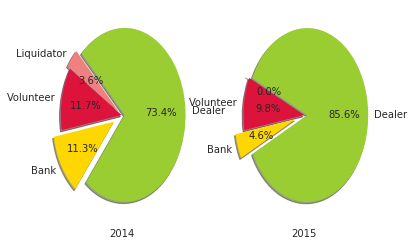

In [65]:
colors = ['gold', 'yellowgreen', 'lightcoral', 'crimson']
explode = (.15, .05, .05, .0)
# ax = empty_axes((16, 8))
axs = (data
 .groupby(["year", "provider"])["multiplier"]
 .count()
 .unstack(level=0)
 .plot(kind='pie', colors=colors, explode=explode, autopct='%1.1f%%', shadow=True, startangle=190, subplots=True)
)

for ax in axs:
    ax.set_xlabel(ax.get_ylabel())
    ax.set_ylabel("")
    ax.get_legend().set_visible(False)
    

            Dealer    Volunteer         Bank
count  3929.000000  3929.000000  3929.000000
mean      0.876304     0.089336     0.034360
std       0.329276     0.285264     0.182175
min       0.000000     0.000000     0.000000
25%       1.000000     0.000000     0.000000
50%       1.000000     0.000000     0.000000
75%       1.000000     0.000000     0.000000
max       1.000000     1.000000     1.000000


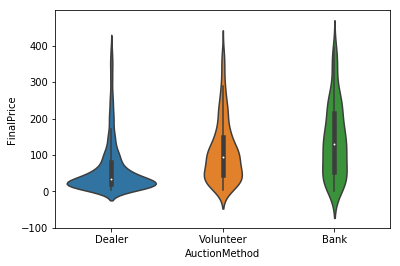

In [338]:
data_2 = data[data['FinalPrice'] < 400]
display(data_2[['Dealer','Volunteer','Bank']].describe())
sns.violinplot(x="AuctionMethod", y="FinalPrice", data=data_2)

            Dealer    Volunteer         Bank
count  4093.000000  4093.000000  4093.000000
mean      0.867090     0.093574     0.039335
std       0.339519     0.291271     0.194416
min       0.000000     0.000000     0.000000
25%       1.000000     0.000000     0.000000
50%       1.000000     0.000000     0.000000
75%       1.000000     0.000000     0.000000
max       1.000000     1.000000     1.000000


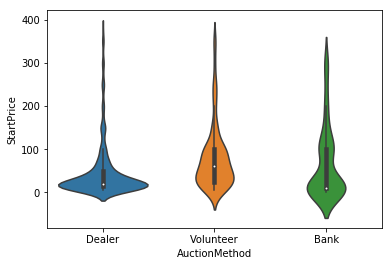

In [339]:
data_3 = data[data['StartPrice'] < 400]
print(data_3[['Dealer','Volunteer','Bank']].describe())
sns.violinplot(x="AuctionMethod", y="StartPrice", data=data_3)

            Dealer    Volunteer         Bank
count  4283.000000  4283.000000  4283.000000
mean      0.862013     0.097829     0.040159
std       0.344927     0.297117     0.196354
min       0.000000     0.000000     0.000000
25%       1.000000     0.000000     0.000000
50%       1.000000     0.000000     0.000000
75%       1.000000     0.000000     0.000000
max       1.000000     1.000000     1.000000


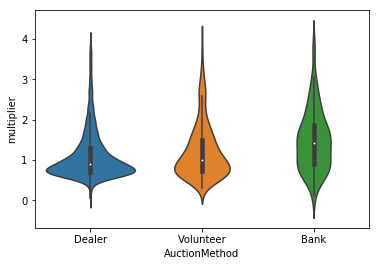

In [340]:
data_4 = data[data['multiplier'] < 4]
print(data_4[['Dealer','Volunteer','Bank']].describe())
sns.violinplot(x="AuctionMethod", y="multiplier", data=data_4)

Text(0,0.5,'Final price')

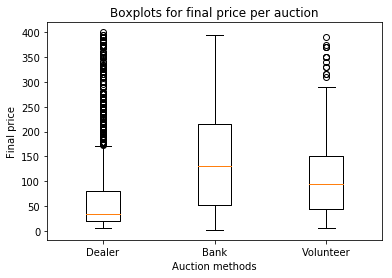

In [260]:
finals_per_auction = []
for x in auctionmethods:
    finals_per_auction.append(data_2['FinalPrice'].loc[data_2['AuctionMethod']==x].values)
plt.boxplot(finals_per_auction)
plt.title('Boxplots for final price per auction')
plt.xticks([1,2,3],auctionmethods)
plt.xlabel('Auction methods')
plt.ylabel('Final price')

Text(0,0.5,'Starting price')

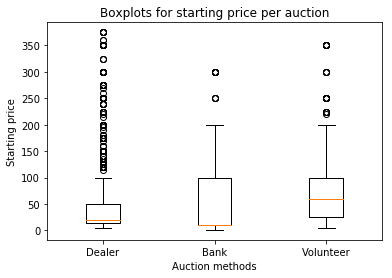

In [261]:
starting_per_auction = []
for x in auctionmethods:
    starting_per_auction.append(data_3['StartPrice'].loc[data_3['AuctionMethod']==x].values)
plt.boxplot(starting_per_auction)
plt.title('Boxplots for starting price per auction')
plt.xticks([1,2,3],auctionmethods)
plt.xlabel('Auction methods')
plt.ylabel('Starting price')

Text(0,0.5,'Multiplier')

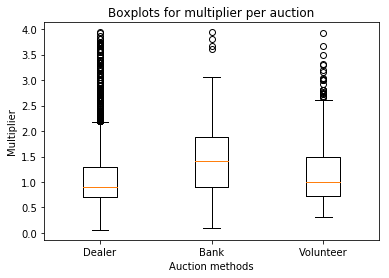

In [263]:
multiplier_per_auction = []
for x in auctionmethods:
    multiplier_per_auction.append(data_4['multiplier'].loc[data_4['AuctionMethod']==x].values)
plt.boxplot(multiplier_per_auction)
plt.title('Boxplots for multiplier per auction')
plt.xticks([1,2,3],auctionmethods)
plt.xlabel('Auction methods')
plt.ylabel('Multiplier')

## Estimated and start value

,EstValue,StartPrice
count,4414.000000,4414.000000
mean,243.189850,162.595831
std,1019.885852,671.279210
min,5.000000,1.000000
25%,25.000000,15.000000
50%,40.000000,25.000000
75%,100.000000,75.000000
max,17500.000000,12500.000000


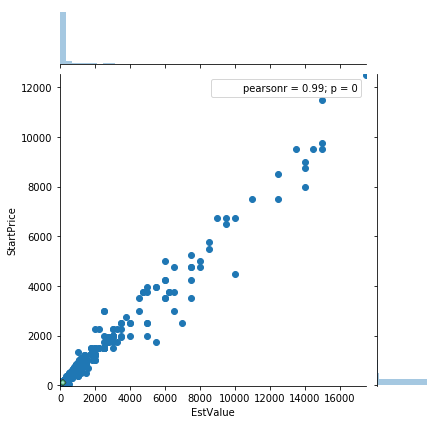

In [268]:
sns.jointplot(x="EstValue", y="StartPrice", data=data).plot_joint(sns.kdeplot)
data[["EstValue", "StartPrice"]].describe()

## Followers, duration

            Dealer    Volunteer         Bank
count  4414.000000  4414.000000  4414.000000
mean      0.856593     0.098097     0.045310
std       0.350527     0.297479     0.208008
min       0.000000     0.000000     0.000000
25%       1.000000     0.000000     0.000000
50%       1.000000     0.000000     0.000000
75%       1.000000     0.000000     0.000000
max       1.000000     1.000000     1.000000


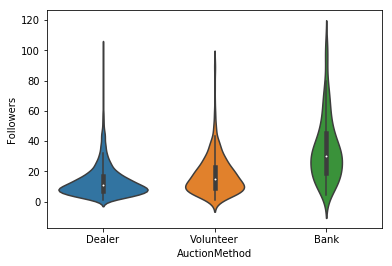

In [320]:
print(data[['Dealer','Volunteer','Bank']].describe())
sns.violinplot(x="AuctionMethod", y="Followers", data=data)

Text(0,0.5,'Duration')

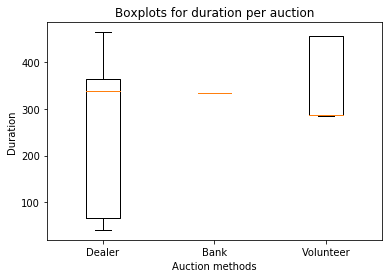

In [323]:
duration_per_auction = []
for x in auctionmethods:
    duration_per_auction.append(data['Duration'].loc[data['AuctionMethod']==x].values)
plt.boxplot(duration_per_auction)
plt.title('Boxplots for duration per auction')
plt.xticks([1,2,3],auctionmethods)
plt.xlabel('Auction methods')
plt.ylabel('Duration')

,Duration,FinalPrice
count,4414.000000,4414.000000
mean,292.927730,294.114862
std,132.359757,1160.366039
min,41.000000,2.000000
25%,286.000000,20.000000
50%,334.000000,46.000000
75%,363.000000,135.000000
max,464.000000,20000.000003


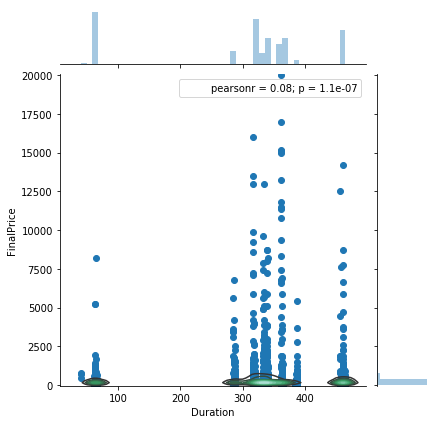

In [328]:
sns.jointplot(x="Duration", y="FinalPrice", data=data).plot_joint(sns.kdeplot)
data[["Duration", "FinalPrice"]].describe()

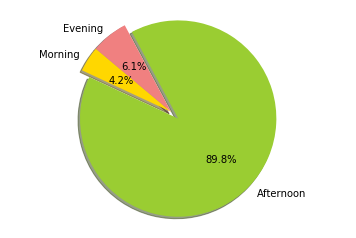

In [332]:
dayperiods = ['Morning','Afternoon','Evening']
distr_dayperiods = []
for x in dayperiods:    
    distr_dayperiods.append(sum(data['DayPeriod']== x))
colors = ['gold', 'yellowgreen', 'lightcoral']
explode = (0, 0.1, 0)  # explode 1st slice
 
# Plot
plt.pie(distr_dayperiods, explode=explode, labels=dayperiods, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.show()

Text(0,0.5,'Final price')

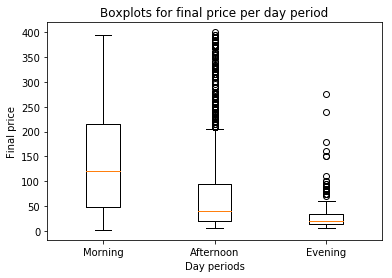

In [341]:
finals_per_dayperiod = []
for x in dayperiods:
    finals_per_dayperiod.append(data_2['FinalPrice'].loc[data_2['DayPeriod']==x].values)
plt.boxplot(finals_per_dayperiod)
plt.title('Boxplots for final price per day period')
plt.xticks([1,2,3],dayperiods)
plt.xlabel('Day periods')
plt.ylabel('Final price')